In [2]:
%matplotlib inline
import numpy as np
import os, sys
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd


In [81]:
params = {
   'axes.labelsize': 14,
   #'text.fontsize': 8,
    'axes.titlesize': 16,
   'legend.fontsize': 14,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'text.usetex': False,
   'figure.figsize': [7, 4] # instead of 4.5, 4.5
   }
matplotlib.rcParams.update(params)

In [4]:
def time_rmse(x1, x2):
    diff = np.square(x1 - x2)
    ex_err = diff.mean(['x', 'y', 'band', 'example'])**0.5
    return ex_err.load()

def read_rmses(inference_dir, max_files=None):
    # get inference files from running Test-Inference.ipynb
    data_files = [os.path.join(inference_dir, f) for f in os.listdir(inference_dir) if f[-3:] == '.nc']
    data_files = sorted(data_files)
    print("Number of files: {}".format(len(data_files)))
    if max_files == None:
        max_files = len(data_files)
        
    linear_rmse, sv_rmse, mv_rmse = [], [], []
    for f in data_files[:max_files]:
        ds = xr.open_mfdataset([f], concat_dim='example')
        ds.t.values = ds.t.values / 15.
        T = len(ds.t)
        ds = ds.isel(t=range(1,T-1))

        linear_rmse.append(ds['linear_rmse'])
        sv_rmse.append(ds['sv_rmse'])
        mv_rmse.append(ds['mv_rmse'])
    
    sv_rmse = xr.concat(sv_rmse,'example')
    mv_rmse = xr.concat(mv_rmse, 'example')
    linear_rmse = xr.concat(linear_rmse, 'example')
    return dict(sv=sv_rmse.compute(), mv=mv_rmse.compute(), linear=linear_rmse.compute())


In [20]:
rmses = dict()
#rmses['3Channels'] = read_rmses('/raid/tj/GOES/SloMo/3Channel-15minute-Inference-Test')
#rmses['8Channels'] = read_rmses('/raid/tj/GOES/SloMo/8Channel-15minute-Inference-Test')

rmses['3Channels'] = read_rmses('/raid/tj/GOES/SloMo/3Channel-15minute-Inference-Hurricane/')
rmses['8Channels'] = read_rmses('/raid/tj/GOES/SloMo/8Channel-15minute-Inference-Hurricane/')

Number of files: 94
Number of files: 94


In [22]:
table1 = []

table1.append(rmses['3Channels']['linear'].mean('example').mean('t').to_pandas())
table1.append(rmses['3Channels']['sv'].mean('example').mean('t').to_pandas())
table1.append(rmses['3Channels']['mv'].mean('example').mean('t').to_pandas())

table1.append(rmses['8Channels']['linear'].mean('example').mean('t').to_pandas())
table1.append(rmses['8Channels']['sv'].mean('example').mean('t').to_pandas())
table1.append(rmses['8Channels']['mv'].mean('example').mean('t').to_pandas())

table1 = pd.concat(table1, axis=1)

table1 = table1.append(table1.ix[:3].mean(axis=0), ignore_index=True)
table1 = table1.append(table1.mean(axis=0, skipna=False), ignore_index=True)
table1.index += 1
table1.columns = ['Linear', 'SV-SloMo', 'MV-SloMo', 'Linear', 'SV-SloMo', 'MV-SloMo']
table1['index'] = [str(i) for i in range(1,9)] + ['3 Band Mean', '8 Band Mean']
table1 = table1.set_index('index')

print(table1.to_latex(float_format=lambda x: '%1.4f' % x))


\begin{tabular}{lrrrrrr}
\toprule
{} &  Linear &  SV-SloMo &  MV-SloMo &  Linear &  SV-SloMo &  MV-SloMo \\
index       &         &           &           &         &           &           \\
\midrule
1           &  0.0295 &    0.0223 &    0.0224 &  0.0295 &    0.0217 &    0.0224 \\
2           &  0.0426 &    0.0340 &    0.0342 &  0.0426 &    0.0336 &    0.0342 \\
3           &  0.0351 &    0.0266 &    0.0267 &  0.0351 &    0.0261 &    0.0267 \\
4           &     nan &       nan &       nan &  0.0106 &    0.0069 &    0.0075 \\
5           &     nan &       nan &       nan &  0.0229 &    0.0177 &    0.0179 \\
6           &     nan &       nan &       nan &  0.0137 &    0.0101 &    0.0103 \\
7           &     nan &       nan &       nan &  0.0017 &    0.0012 &    0.0012 \\
8           &     nan &       nan &       nan &  0.0024 &    0.0018 &    0.0018 \\
3 Band Mean &  0.0358 &    0.0276 &    0.0278 &  0.0358 &    0.0271 &    0.0278 \\
8 Band Mean &     nan &       nan &       nan &  0.02

/home/tj/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


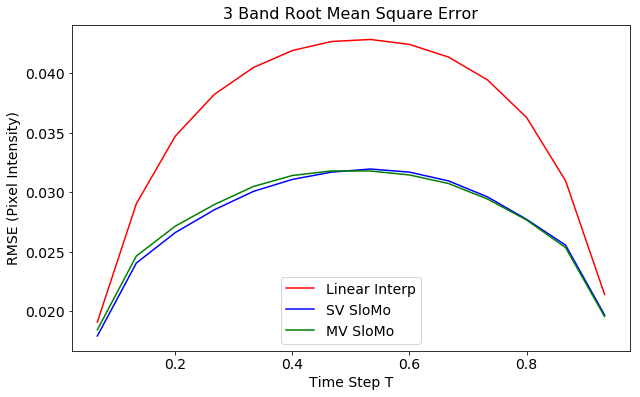

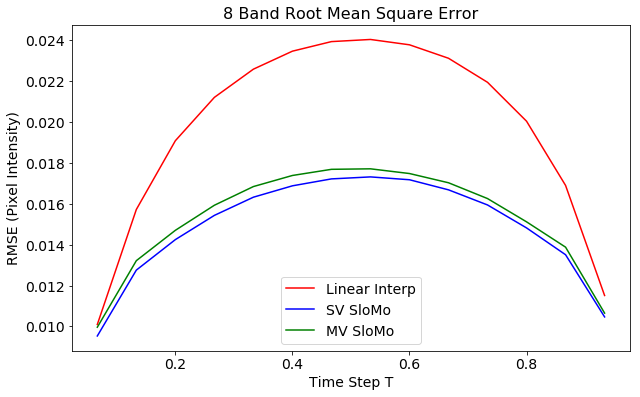

In [28]:
fig = plt.figure(figsize=(10,6))
rmses['3Channels']['linear'].mean('example').mean('band').compute().plot(color='red', label='Linear Interp')
rmses['3Channels']['sv'].mean('example').mean('band').compute().plot(color='blue', label='SV SloMo')
rmses['3Channels']['mv'].mean('example').mean('band').compute().plot(color='green', label='MV SloMo')
#plt.
plt.xlabel("Time Step T")
plt.ylabel("RMSE (Pixel Intensity)")
plt.title("3 Band Root Mean Square Error")
plt.legend()
plt.savefig("figures/3band-error-curve.png", dpi=200)
plt.show()

fig = plt.figure(figsize=(10,6))
rmses['8Channels']['linear'].mean('example').mean('band').compute().plot(color='red', label='Linear Interp')
rmses['8Channels']['sv'].mean('example').mean('band').compute().plot(color='blue', label='SV SloMo')
rmses['8Channels']['mv'].mean('example').mean('band').compute().plot(color='green', label='MV SloMo')
#plt.
plt.xlabel("Time Step T")
plt.ylabel("RMSE (Pixel Intensity)")
plt.title("8 Band Root Mean Square Error")
plt.legend()
plt.savefig("figures/8band-error-curve.png", dpi=200)
plt.show()


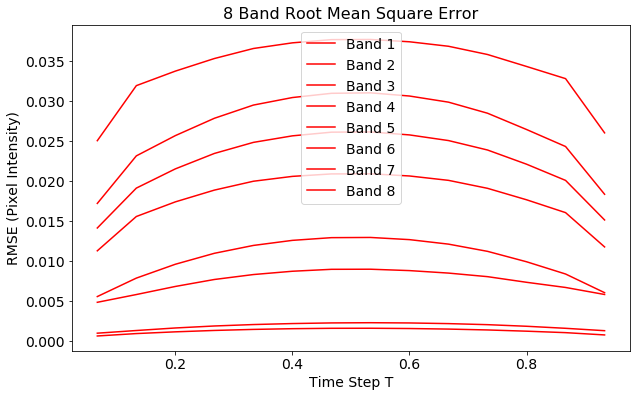

In [27]:
fig = plt.figure(figsize=(10,6))

banderrs = rmses['8Channels']['mv'].mean('example').compute()

for b in banderrs.band.values:
    banderrs.sel(band=b).plot(color='red', label='Band %i' % b)

plt.xlabel("Time Step T")
plt.ylabel("RMSE (Pixel Intensity)")
plt.title("8 Band Root Mean Square Error")
plt.legend()
plt.show()


In [84]:
# Time Series
inference_dir = '/raid/tj/GOES/SloMo/8Channel-15minute-Inference-Hurricane/'
data_files = [os.path.join(inference_dir, f) for f in os.listdir(inference_dir) if f[-3:] == '.nc']
data_files = sorted(data_files)
print("Number of files: {}".format(len(data_files)))

ix = 250
iy = 250

obs_ts, sv_ts, ln_ts = [], [], []
for f in data_files:
    ds = xr.open_mfdataset([f], concat_dim='example')
    obs_ts.append(ds.isel(x=ix, y=iy, band=1)['observed'].compute().values[0])
    sv_ts.append(ds.isel(x=ix, y=iy, band=1)['slomo_mv'].compute().values[0])
    ln_ts.append(ds.isel(x=ix, y=iy, band=1)['linear'].compute().values[0])

Number of files: 94


(1504,)


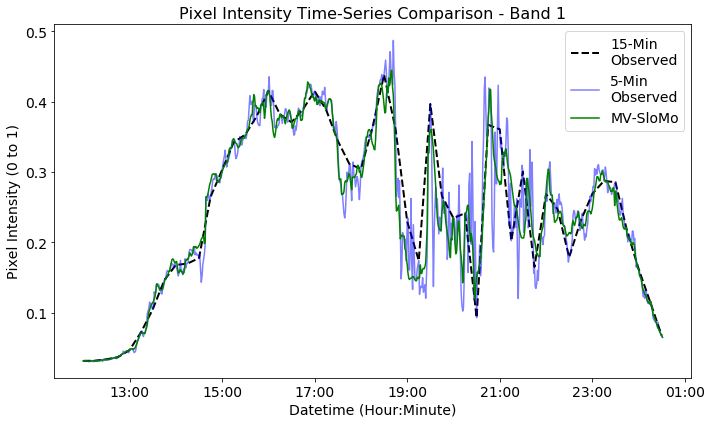

In [144]:
obs_ts_np = np.concatenate(obs_ts)
sv_ts_np = np.concatenate(sv_ts)
ln_ts_np = np.concatenate(ln_ts)


print(sv_ts_np.shape)
n_half = sv_ts_np.shape[0]/2

obs_ts_np = obs_ts_np[-n_half:]
sv_ts_np = sv_ts_np[-n_half:]
ln_ts_np = ln_ts_np[-n_half:]

x = np.arange(0, n_half)
x15 = np.arange(0, n_half, 15)
xt = np.array([datetime.datetime(2018, 10, 8, 12) + datetime.timedelta(minutes=i) for i in x])

# Define the date format
from matplotlib.dates import DateFormatter

myfmt = DateFormatter("H:M") 

fig, ax = plt.subplots(figsize = (10,6))
ax.plot_date(xt[x15], obs_ts_np[x15], ls='--', lw=2, color='black', label='15-Min\nObserved', ms=0.)
ax.plot_date(xt, obs_ts_np, label='5-Min\nObserved', ls='-', ms=0, color='blue', alpha=0.5)
ax.plot_date(xt, sv_ts_np, label='MV-SloMo', ls='-', ms=0, color='green')
ax.xaxis.set_major_formatter(myFmt); 

#plt.plot(x, ln_ts_np, label='Linear', color='red')
plt.legend()
plt.xlabel("Datetime (Hour:Minute)")
plt.ylabel("Pixel Intensity (0 to 1)")
plt.title("Pixel Intensity Time-Series Comparison - Band 1")
plt.tight_layout()
plt.savefig("figures/time-series.png")

In [94]:
import datetime

xt

TypeError: 'numpy.int64' object is not iterable